# 0.0.Entendendo o Problema

- 1.Objetivo do Projeto:
    - 1.1.Classificar se o cliente vai ser inadimplente ou não.
    
    
- 2.Por que o projeto está sendo requistado?
    - 2.1.Acredito que seja pelo motivo de que a empresa está desenvolvendo um sistema de crédito automatico que de um limite adequado para a situação que o cliente está, pois caso a empresa de um emprestimo muito alto para clientes que vão ser possivelmente inadimplentes ela vai está pedenndo dinheiro, pois terá muito mais prejuizo do lucro com esse cliente, em contra partida também temos os clientes que não vão ser inadimplentes e esses sim deve receber um crédito alto para que se fidelizem com o banco e gastem mais, acredito que seja isso.
    
    
- 3.Qual métrica do negócio o projeto vai afetar?

    - 3.1.Em outras palavras onde o projeto vai ajudar a empresa a ganhar mais dinheiro? bem, acredito que os bancos ganhem dinheiro através dos juros pois quando emprestam uma quantidade x para o cliente tendem a receber uma quantidade y maior do que deram, ou seja, o projeto vai afetar na métrica de aumento do lucro da empresa e a queda do prejuizo, pois no fim uma das grandes formas dos bancos ganharem dinherio e através desse metódo.
        - Receita = juros que vem dos créditos
        - + Mais clientes(não inadimplente) + juros = Receita.
        
    - 3.2.No fim vamos buscar melhorar a métrica de juros, pois a empresa sabendo qual e o cliente com menos chance de ser inadimplente vai poder investir mais nele, e esse investimento ira trazer mais juros pois o cliente vai gasta mais, e isso vai fazer o faturamento da empresa aumentar.
 
 
- 4.Proposta de Solução
    - 4.1.Para resolver esse problema eu vou criar um modelo de Machine Learning que consiga indentificar quais são os clientes com maiores chances de serem inadimplentes, o modelo vai pedir as informações sobre o cliente e no fim retorna a classificação dele, para fazer isso será necessario passar por diversos ciclos para indentificação de problemas, pois cada problema dependendo da proporção vai gerar um novo ciclo, por exemplo certamente vamos está lidando com dados desbalaceandos, estão vamos precisa de um ciclo de balanceamento de dados.
    
- 5.O que será entrgue no fim?
    - 5.1.No fim dos ciclos do projeto eu espero ter um modelo que Tenha uma precisão de indentificar clientes inadimplente maior de 75%
    - 5.2.Um WebApp que vai funciona da seguiente forma:
        - input: Dados do clientes, as features que o modelo usou para indentificar se vai inadimplente ou não.
        - output: Uma foto que sendo verde significa que o cliente não vai ser inadimplente e caso ele for inadimplente retorna uma foto vermelha.
        
        
obs: Eu sei que existem outras formas dos bancos ganherem dinheiro, mas vou simplificar aqui falando apenas do juros, já que e a métrica que vamos buscar melhorar.

# 1.0.Imports

In [1]:
#Libraries Paddron
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import random
#--------------------
#Machine Learning Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
#--------------------
#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score
from scikitplot import metrics as mt
#--------------------
#Regex
import re
#--------------------
#balanced data
from imblearn import combine as c
#--------------------
#Feature Selection
from boruta import BorutaPy
#--------------------
#Rescaling and Enconder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from category_encoders import CountEncoder
from sklearn import preprocessing as pp
#--------------------

#Report
from pandas_profiling import ProfileReport
#--------------------

#Filter Warnings
import warnings
warnings.filterwarnings("ignore")
#-------------------
## Statiscts
from scipy import stats
#------------------

#Show all columns
pd.set_option('display.max_columns', None)

#Style of matplotlib
plt.style.use('ggplot')

## 1.1.Load Data

In [2]:
df_raw = pd.read_csv('datasets/acquisition_train.csv')

## 1.2.Help Functions

In [3]:
def cross_validation(model,num_folds,x_train,y_train,verbose=False):
    r2_list  = []
    rmse_list   = []
    mae_list    = []
    mape_list   = []
    
    #generate k-fold
    Kfold = StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=32)
    
    i=1
    for train_ix, val_ix in Kfold.split(X_train,y_train):
        if verbose:
            print('Fold Number: {}/{}'.format(i,num_folds))
        
        #get fold
        x_train_fold = X_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]
        
        x_val_fold = X_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]
        
        
        #Model train
        model.fit(x_train_fold,y_train_fold)

        #prediction
        pred_nn = model.predict(x_val_fold)
        
        #Metrics
        acc = accuracy_score(y_val_fold,pred_nn)
        print('Acurracy: {:.2%}'.format(acc))
        
        balacend_acc = balanced_accuracy_score(y_val_fold,pred_nn)
        print('Balacend Acurracy: {:.2%}'.format(balacend_acc))

        #Kappa Metric
        kappa_acc = cohen_kappa_score(y_val_fold,pred_nn)
        print('Kappa Score: {:.2%}'.format(kappa_acc))

        #classification_report
        print(classification_report(y_val_fold,pred_nn))

        #plot confusion matrix
        mt.plot_confusion_matrix(y_val_fold, pred_nn, normalize=True, figsize=(6,6));
        
        return None


def data_dimensions(df):
    print('Number of Rows: {}'.format(df.shape[0]))
    print('Number of Columns: {}'.format(df.shape[1]))
    return None


def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2-(k-1)*(r-1)/(n-1))
    
    kcorr= k - (k-1)**2/(n-1)
    rcorr= r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1) ))


def getcountplot(df,col):
    plt.figure(figsize=(24,12))
    sns.countplot(df[col],palette='plasma')
    plt.xticks(rotation = '45',fontweight = 'bold',fontsize = '10')
    plt.yticks(rotation = '45',fontweight = 'bold',fontsize = '10')
    plt.show()
    return None

# 2.0.Data Description

In [4]:
df1 = df_raw.copy()
df1.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


## 2.1.Data Dimensions

In [5]:
data_dimensions(df1)

Number of Rows: 45000
Number of Columns: 43


## 2.2.Data types

In [6]:
df1.dtypes

ids                                                  object
target_default                                       object
score_1                                              object
score_2                                              object
score_3                                             float64
score_4                                             float64
score_5                                             float64
score_6                                             float64
risk_rate                                           float64
last_amount_borrowed                                float64
last_borrowed_in_months                             float64
credit_limit                                        float64
reason                                               object
income                                              float64
facebook_profile                                     object
state                                                object
zip                                     

## 2.3.Change types

In [7]:
#None

## 2.4.Check NA values

**Removendo colunas:**
Todas as colunas que tiverem 50% ou mais de valores nulos eu vou remover, pelo motivo de eu não querer mudar o fenomeno que estou tentando modelar, pois vou acabar inviezando o modelo e criando algo que não condiz com a realidade.

In [8]:
aux = pd.DataFrame(index=df1.isnull().sum().index, data=df1.isnull().sum().values).rename(columns={0:'Values NA'})
aux = aux.sort_values(by='Values NA',ascending=False)
aux['% NA'] = 100*round(df1.isnull().sum() / len(df1),2)
aux[(aux['Values NA'] > 0) & (aux['% NA'] > 50)] #cols to drop

,Values NA,% NA
target_fraud,43478,97.0
last_amount_borrowed,29956,67.0
last_borrowed_in_months,29956,67.0
ok_since,26545,59.0


In [9]:
aux[(aux['Values NA'] > 0) & (aux['% NA'] < 50)] # cols to fill

,Values NA,% NA
external_data_provider_credit_checks_last_year,15124,34.0
credit_limit,13800,31.0
n_issues,11544,26.0
facebook_profile,4458,10.0
marketing_channel,3578,8.0
job_name,3336,7.0
target_default,3259,7.0
external_data_provider_email_seen_before,2233,5.0
lat_lon,1363,3.0
user_agent,722,2.0


## 2.5.FIll or Drop NA values

**Preenchendo valores nulos:**

- Colunas Numericas:

    - Para preecher as variaveis continuas eu analise as médidas de posição central e a distribuição da variavel, para ter certeza que não ia está modificando o fenemeno, então cada variavel que eu substituir o valor pela média e mediana foi pelo fato de está proximo de uma distribuição normal.

- Colunas Categoricas:

  - Já as variaveis categoricas eu busquei substituir pela moda, claro que tenho o conhecimento de que pequenas mundaçãs assim podem inviezar o modelo e fazer ele aprender algo que não condiz com a realidade, mas vai ser um teste, caso eu veja que o modelo não está perfomando bem, principalmente na cross_validation eu volto aqui e faço outra substituição de dados.

In [10]:
cols_na = ['target_fraud','last_amount_borrowed','last_borrowed_in_months','ok_since',
           'external_data_provider_credit_checks_last_2_year', # columns with a large quantity of na valeus (=>50%)
           'user_agent','profile_tags'] #columns I think it has little relevance

df1 = df1.drop(cols_na,axis=1)

### 2.5.1.Fill NA values with mean

In [11]:
#score_3
df1['score_3'] = df1['score_3'].fillna(df1['score_3'].mean())
#risk_rate
df1['risk_rate'] = df1['risk_rate'].fillna(df1['risk_rate'].mean())
#income
df1['income'] = df1['income'].fillna(df1['income'].median())
#n_accounts
df1['n_accounts'] = df1['n_accounts'].fillna(df1['n_accounts'].mean())

### 2.5.2.Fill NA values with median

In [12]:
#n_issues
#method = fill values with median
#reason = because the values is approached to normal distribution
df1['n_issues'] = df1['n_issues'].fillna(df1['n_issues'].median())

### 2.5.3.Fill Na values with mode

In [13]:
#marketing_channel
df1['marketing_channel'] = df1['marketing_channel'].fillna(df1['marketing_channel'].mode(0)[0])

#job_name
df1['job_name'] = df1['job_name'].fillna(df1['job_name'].mode(1)[0])

#external_data_provider_email_seen_before
df1['external_data_provider_email_seen_before'] = df1['external_data_provider_email_seen_before'].fillna(df1['external_data_provider_email_seen_before'].mode(1)[0])

#n_bankruptcies
df1['n_bankruptcies'] = df1['n_bankruptcies'].fillna(df1['n_bankruptcies'].mode(0)[0])

#n_defaulted_loans
df1['n_defaulted_loans'] = df1['n_defaulted_loans'].fillna(df1['n_defaulted_loans'].mode(0)[0])

#reason
df1['reason'] = df1['reason'].fillna(df1['reason'].mode(0)[0])

#channel
df1['channel'] = df1['channel'].fillna(df1['channel'].mode(0)[0])

#score_1
df1['score_1'] = df1['score_1'].fillna(df1['score_1'].mode(0)[0])

#real_state
df1['real_state'] = df1['real_state'].fillna(df1['real_state'].mode(0)[0])

#state
df1['state'] = df1['state'].fillna(df1['state'].mode(0)[0])

#score_2
df1['score_2'] = df1['score_2'].fillna(df1['score_2'].mode(0)[0])

#lat_lon
df1['lat_lon'] = df1['lat_lon'].fillna(df1['lat_lon'].mode(1)[0])

### 2.5.4.Fill NA values with another values

In [14]:
#external_data_provider_credit_checks_last_year
#resoan = substitution with random values to avoid data unbalanced(its a test)
df1['external_data_provider_credit_checks_last_year'] = df1['external_data_provider_credit_checks_last_year'].fillna(random.choice([0,1]))

#credit_limit
#reason = because na values represents to my that this persoan dont have credit limit
df1['credit_limit'] = df1['credit_limit'].fillna(0)


#reason = because Na values in this columns represents to my that person don't have or don't passed zip and facebook profile.
#zip
df1['zip'] = df1['zip'].fillna('no address')
#facebook_profile
df1['facebook_profile'] = df1['facebook_profile'].fillna(False)

In [15]:
#target_default and lat_lon
#reason: target_default: bacause its my target variable
df1 = df1.dropna()

In [16]:
df1.isnull().sum()

ids                                                0
target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
credit_limit                                       0
reason                                             0
income                                             0
facebook_profile                                   0
state                                              0
zip                                                0
channel                                            0
job_name                                           0
real_state                                         0
n_bankruptcies                                

In [17]:
data_dimensions(df1)

Number of Rows: 41741
Number of Columns: 36


## 2.6. Data Cleaning

In [18]:
#cleaning up additional space
df1['target_default'] = df1['target_default'].apply(lambda x: str(x).strip())

#clean up emails
df1['email'] = df1['email'].apply(lambda x: 'gmail.com'   if x == 'gmaill.com' else
                                            'hotmail.com' if x == 'hotmaill.com' else x)

#clean up facebook with additional space - i found this problem in data preparation step.
df1['facebook_profile'] = df1['facebook_profile'].apply(lambda x: str(x).strip())

## 2.7.Descriptive Analysis

In [19]:
number_attributes = df1.select_dtypes(include=['int64','float64'])
categorical_attributes = df1.select_dtypes(include=['object'])

### Columns Numbers Descriptives

**Analise das Metricas:**

**Filtrando a coluna Income:**
A coluna de income possui valores muito fora da realidade, que podem sim ser verdade pois a nubank pode ter mesmo empresas cliente que ganhem milhões e bilhões, mas são poucos e não e esse o nosso objetivo aqui no projeto, já que queremos descobrir se o cliente vai ser inadimplente ou não, então estamos lidando com pessoas fisicas aqui e não empresas, por esse motivo eu vou filtrar minha coluna de income para pegar apenas as pessoas com renda menor de 300 mil, que já acho que é um limite grande que foge da realidade de muitas pessoas, mas que já vai nos possibilitar ter um modelo mais preciso para pessoas fisicas.

**Filtrando a coluna Credit_Limit:**
Pelo mesmo motivo da filtragem da coluna de income, estámos focando aqui no projeto em descobrir se pessoas fisicas vão ser inadimplentes ou não, embora a nubank possua clientes que possuem uma renda maior, eles não são a maioria por isso eu vou escolher filtrar essa coluna para pegar apenas o pessoal com limite de crédito menor que 100 mil, que e um valor que ainda está muito longe da realidade das pessoas classe média e baixa.

**Filtrando a coluna reported_income:**
Essa coluna eu já venho filtrando desde a primeira etapa, pois ela é uma coluna que possui valores inf que quer dizer infito ou seja um erro na hora de digitar o valor da renda da pessoa ou do sistema, por isso eu vou remover da minha base.

In [20]:
#Central Tendency - Mean - Median - Mode
ct1 = pd.DataFrame(number_attributes.apply(np.mean)).T.round(2)
ct2 = pd.DataFrame(number_attributes.apply(np.median)).T.round(2)
ct3 = pd.DataFrame(number_attributes.apply(lambda x: x.mode()[0])).T.round(2)

#Dispensions - STD - Min - MAX - Range - Skew - Kurtosis
d1 = pd.DataFrame(number_attributes.apply(np.std)).T.round(2)
d2 = pd.DataFrame(number_attributes.apply(min)).T.round(2)
d3 = pd.DataFrame(number_attributes.apply(max)).T.round(2)
d4 = pd.DataFrame(number_attributes.apply(lambda x: x.max() - x.min())).T.round(2)
d5 = pd.DataFrame(number_attributes.apply(lambda x: x.skew())).T.round(2)
d6 = pd.DataFrame(number_attributes.apply(lambda x: x.kurtosis())).T.round(2)

#Concat all metrics
metrics = pd.concat([d2,d3,d4,ct1,ct2,ct3,d1,d5,d6]).T.reset_index()
metrics.columns = ['attributes','min','max','range','mean','median','mode','std','skew','kurtosis']
metrics

,attributes,min,max,range,mean,median,mode,std,skew,kurtosis
0,score_3,0.00,990.00,990.00,346.46,340.00,330.00,110.10,0.35,0.14
1,score_4,86.19,113.98,27.79,100.01,100.02,86.19,3.18,-0.02,0.03
2,score_5,0.00,1.00,1.00,0.50,0.50,0.00,0.29,0.00,-1.19
3,score_6,60.66,142.19,81.53,99.92,99.98,60.66,10.02,-0.02,-0.01
4,risk_rate,0.00,0.90,0.90,0.29,0.29,0.28,0.10,0.48,0.33
5,credit_limit,0.00,448269.00,448269.00,23237.89,11134.00,0.00,33811.45,2.86,14.57
6,income,4821.18,5000027.83,4995206.65,71080.12,60044.09,60025.51,52259.15,24.63,1979.90
7,n_bankruptcies,0.00,5.00,5.00,0.08,0.00,0.00,0.27,3.79,18.69
8,n_defaulted_loans,0.00,5.00,5.00,0.00,0.00,0.00,0.08,23.33,775.04
9,n_accounts,0.00,49.00,49.00,10.64,10.00,9.00,4.59,0.95,1.66


### Columns Categorical  Descriptives

**Analise do Describe:**

Analisando o describe das minhas variaveis categoricas, percebo que existem muitas categorias com valores muito distintos, como por exemplo:

- Reason: Possui mais de 14 mil valores distintos
- zip: Possui 832 valores distintos
- job_name: Possui 30 mil valores distintos
- external_data_provider_first_name: Possui mais de 30 mais valores distintos
- profile_phone_number: Possui mais de 40 mil valores distintos

**Qual o problema de ter colunas com tantos valores distintos?**
O problema e na hora de encondar essas variaveis, pois tantos valores distintos fica complicado de fazer certos tipos de enconders, claro que ainda é possivel e eu vou encondar, mas nessa análise já posso notar algumas colunas que eu acredito que não vão ter relavancia pro modelo, que são:

- external_data_provider_first_name
- profile_phone_number

por serem colunas de informações pessoais da pessoa, ela não tem relavancia na hora de prever se a pessoa vai ser inadimplente ou não, então eu vou remover elas, as outras colunas com muitos valores distintos eu vou encondar, mas isso e nas próximas etapas.

In [21]:
categorical_attributes.describe()

,ids,target_default,score_1,score_2,reason,facebook_profile,state,zip,channel,job_name,real_state,application_time_applied,email,external_data_provider_first_name,lat_lon,marketing_channel,profile_phone_number,shipping_state
count,41741,41741,41741,41741,41741,41741,41741,41741,41741,41741,41741,41741,41741,41741,41741,41741,41741,41741
unique,41741,2,7,35,14260,2,50,823,1,30543,5,33560,4,31183,21596,9,41741,25
top,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,DGCQep2AE5QRkNCshIAlFQ==,osCzpM4hJrxugqWWuZmMWw==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,False,xsd3ZdsI3356I3xMxZeiqQ==,3k2JCQ8Bp5oDwaI39ZJgHA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,18:02:09,gmail.com,jordanio,"(-5.164423488858103, -37.356920426246845)",Website,514-9840782,BR-SP
freq,1,35080,14142,3466,4068,27806,7123,538,41741,2768,20647,6,21035,6,1279,13471,1,6495


## 2.8.Check Balanced Data

In [22]:
df1['target_default'].value_counts(normalize=True)

False    0.840421
True     0.159579
Name: target_default, dtype: float64

# 3.0.Feature Engienner

In [23]:
df2 = df1.copy()
df2.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,False,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,10.0,10.0,00:60:02,6,gmail.com,2,0.0,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,3,0.0,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,11.0,10.0,13:39:03,240,gmail.com,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827


In [24]:
df2.columns

Index(['ids', 'target_default', 'score_1', 'score_2', 'score_3', 'score_4',
       'score_5', 'score_6', 'risk_rate', 'credit_limit', 'reason', 'income',
       'facebook_profile', 'state', 'zip', 'channel', 'job_name', 'real_state',
       'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues',
       'application_time_applied', 'application_time_in_funnel', 'email',
       'external_data_provider_credit_checks_last_month',
       'external_data_provider_credit_checks_last_year',
       'external_data_provider_email_seen_before',
       'external_data_provider_first_name',
       'external_data_provider_fraud_score', 'lat_lon', 'marketing_channel',
       'profile_phone_number', 'reported_income', 'shipping_state',
       'shipping_zip_code'],
      dtype='object')

## News Columns

In [25]:
#Split lat_lon to lat and lon
lat=[]
lon=[]
for i in df1['lat_lon']:
    try:
        lat.append(i.split(',')[0].replace('(','').strip())
        lon.append(i.split(',')[1].replace(')','').strip())
    except:
        lat.append('')
        lon.append(np.NaN)
        
#news features 
df2['lat'] = lat
df2['lon'] = lon

#change dtypes
df2['lat'] = df2['lat'].astype(np.float64)
df2['lon'] = df2['lon'].astype(np.float64)


#Split column with Hour:Minute:Second to Hour, Minute and Second
hour = []
minute = []
second = []

for i in df2['application_time_applied']:
    try:
        hour.append(datetime.strptime(i,'%H:%M:%S').hour)
        minute.append(datetime.strptime(i,'%H:%M:%S').minute)
        second.append(datetime.strptime(i,'%H:%M:%S').second)
    except:
        hour.append(np.NaN)
        minute.append(np.NaN)
        second.append(np.NaN)

#create news columns
df2['hour'] = hour
df2['minute'] = minute
df2['second'] = second

#Drop NA values create by split variables
df2 = df2.dropna()

#change dtypes
df2['hour'] = df2['hour'].astype(np.int64)
df2['minute'] = df2['minute'].astype(np.int64)
df2['second'] = df2['second'].astype(np.int64)

df2['class'] = df2['income'].apply(lambda x: 'low_class' if x < 30000 else
                               'middle_class' if x < 100000 else 'high_class')

#Drop columns
df2 = df2.drop(['application_time_applied','lat_lon'],axis=1)

In [26]:
data_dimensions(df2)

Number of Rows: 38847
Number of Columns: 40


# 4.0.Data Filtering

In [27]:
df3 = df2.copy()
df3.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,lat,lon,hour,minute,second,class
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,18.0,18.0,444,outlook.com,2,0.0,51.0,leidelaura,645,Invite-email,514-9840782,57849.0,BR-MT,17528,-29.151546,-51.138646,7,52,34,middle_class
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,14.0,14.0,346,gmail.com,1,0.0,17.0,diocezio,243,Radio-commercial,251-3659293,4902.0,BR-RS,40933,-19.687711,-47.941515,2,34,29,high_class
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,1.0,0.0,19.0,19.0,406,spgov.com,3,0.0,38.0,venice,815,Waiting-list,261-3543751,1086.0,BR-RN,37825,-17.520650,-39.758011,11,20,49,middle_class
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,11.0,10.0,240,gmail.com,2,1.0,46.0,darzisa,320,Invite-email,102-3660162,198618.0,BR-MT,52827,-16.574259,-39.909901,13,39,3,middle_class
5,538c1908-bd80-b834-c3f0-238b4f536d3f,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,300.0,101.837040,0.915389,90.711273,0.44,61055.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,75024.28,False,JrdZzPZEa/YIIGwh8OdTKA==,kfWDI5wYFHdi9PtKFI9EPg==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,9.0,9.0,169,gmail.com,2,1.0,21.0,teomar,811,Website,787-1678197,160198.0,BR-SP,55266,-6.762413,-35.132246,5,27,2,middle_class


## 4.1.Filter Rows

In [28]:
#Drop data with value Infinit, filter income to get values < 300000 and filter credit_limit to get values < 100 mil
df3 = df3[df3['reported_income']!= np.inf]
df3 = df3[df3['income'] < 300000]
df3 = df3[df3['credit_limit'] < 100000]

## 4.2.Filter columns

In [29]:
cols_remove = ['external_data_provider_first_name','profile_phone_number', #columns I think it has little relevance
               'n_bankruptcies', 'n_defaulted_loans', 'reported_income','channel','n_issues','score_2'] # columns chosen to be removed in the data exploration step
df3 = df3.drop(cols_remove,axis=1)

In [30]:
data_dimensions(df3)

Number of Rows: 37354
Number of Columns: 32


# 5.0.Balanced Dataset

**Criando um Ratio Balanced:**

Como estamos lidando com um problema que possui uma natureza de desbalaceamento natural eu não posso simplesmente pegar minha variavel True que me diz que o cliente é inadimplente e deixar ela com do mesmo tamanho da false quando o cliente não e inadimplente, por isso eu ainda vou deixar os dados um tanto desbalaceados para garatir que não estou alterando a natureza do meus dados.

**Técnica usada:**

Vou usar uma técnica de Oversampling que significa que eu vou deixa a minha variavel desbalaceada próxima do tamanho da minha variavel majoritaria, para fazer isso eu vou usar uma tecnica que cria dados sintéticos.

In [31]:
df4 = df3.copy()
df4.head()

,ids,target_default,score_1,score_3,score_4,score_5,score_6,risk_rate,credit_limit,reason,income,facebook_profile,state,zip,job_name,real_state,n_accounts,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,marketing_channel,shipping_state,shipping_zip_code,lat,lon,hour,minute,second,class
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,350.0,101.800832,0.259555,108.427273,0.40,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,18.0,444,outlook.com,2,0.0,51.0,645,Invite-email,BR-MT,17528,-29.151546,-51.138646,7,52,34,middle_class
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,370.0,97.062615,0.942655,92.002546,0.24,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,14.0,346,gmail.com,1,0.0,17.0,243,Radio-commercial,BR-RS,40933,-19.687711,-47.941515,2,34,29,high_class
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,510.0,101.599485,0.987673,94.902491,0.32,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,19.0,406,spgov.com,3,0.0,38.0,815,Waiting-list,BR-RN,37825,-17.520650,-39.758011,11,20,49,middle_class
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,500.0,98.474289,0.532539,118.126207,0.18,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,11.0,240,gmail.com,2,1.0,46.0,320,Invite-email,BR-MT,52827,-16.574259,-39.909901,13,39,3,middle_class
5,538c1908-bd80-b834-c3f0-238b4f536d3f,False,8k8UDR4Yx0qasAjkGrUZLw==,300.0,101.837040,0.915389,90.711273,0.44,61055.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,75024.28,False,JrdZzPZEa/YIIGwh8OdTKA==,kfWDI5wYFHdi9PtKFI9EPg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,9.0,169,gmail.com,2,1.0,21.0,811,Website,BR-SP,55266,-6.762413,-35.132246,5,27,2,middle_class


In [32]:
#Count Frequency Enconder and Lalbel Enconder
#Count Frequency to balancing data.
fq   =  CountEncoder()
lb   = LabelEncoder()

df4['state'] = fq.fit_transform(df4['state'])

df4['score_1'] = fq.fit_transform(df4['score_1'])

df4['marketing_channel'] = fq.fit_transform(df4['marketing_channel'])

df4['zip'] = fq.fit_transform(df4['zip'])

df4['job_name'] = fq.fit_transform(df4['job_name'])

df4['reason'] = fq.fit_transform(df4['reason'])


#Label id enconder
df4['ids'] = lb.fit_transform(df4['ids']).astype(np.int64)

In [33]:
#Enconder Categorical Variables
ohe  = pp.OneHotEncoder()

#numerical
col_num = df4.select_dtypes(include=['int64','float64']).columns.tolist()

#categorical
col_cat = df4.select_dtypes(exclude=['int64','float64']).drop('target_default',axis=1).columns.tolist()
                                                             
    
#Encondig
df4_dummy = pd.DataFrame(ohe.fit_transform(df4[col_cat]).toarray(),index=df4.index)

#join numerical and categorical
df42 = pd.concat([df4[col_num],df4_dummy],axis=1)

In [34]:
ratio_balanced = {'False':32408,
                  'True':6201*4}
ratio_balanced

{'False': 32408, 'True': 24804}

In [35]:
#define smote and tomeklink
smt = c.SMOTETomek(sampling_strategy=ratio_balanced,random_state=32,n_jobs=-1)

#X and y with balanced data
X_smt, y_smt = smt.fit_resample(df42,df4['target_default'])

In [36]:
#numerical numbers
df43 = X_smt[col_num]

#categorical data
df44 = X_smt.drop(col_num,axis=1)
df45 = pd.DataFrame(ohe.inverse_transform(df44),columns=col_cat,index=df44.index)

#join num + cat
df46 = pd.concat([df43,df45],axis=1)
df46['target_default'] = y_smt

In [37]:
#Data Balanced
df46['target_default'].value_counts()

False    32009
True     24405
Name: target_default, dtype: int64

In [38]:
data_dimensions(df46)

Number of Rows: 56414
Number of Columns: 32


# 6.0.Exploratory Data Analysis(EDA)

In [39]:
df5  = df4.copy() #Unbalanced Dataset
df51 = df46.copy() #Balanced Dataset

## 6.1.Univariate analysis - (Balanced DataSet)

### 6.1.1.Numerical Variables

**ANALISES RETIRADAS DO GRAFICO ABAIXO:**

As analises vão conter o meu entendimento a analisar cada variável por vez, caso eu ache a variável irrelevante eu vou escolher remover ela e vou dizer o motivo.

**Score_3:**

Essa feature possui uma distribuição quase normal, por esse motivo vou escolher **Manter ela** no meu dataset, já que os modelos de Machine Learning em sua grande maioria esperam que a feature esteja nessa distribuição ou uma distribuição normal.

**Score_4:**

Mesma análise que fiz para Score_3, vou escolher **Manter ela**.

**Score_5:**

Essa e o tipo de feature que me deixa com dúvidas se vale ou não a pena deixa ela no meu dataset, por esse motivo vou escolher **Manter ela** pois na etapa de feature selection, vai ser a etapa que vou me dedicar 100% em escolher as melhores features, nessa etapa eu vou usar modos mais avançados, então eu vou deixar para ter a certeza se vale ou não a pena nessa etapa.


**Score_6:**

Mesma análise que fiz para Score 3 e 4, então vou escolher **Manter ela.**

**risk_rate:**

Essa com certeza vai ser muito importante para o modelo, sinto que ela vai ser uma das principais, pela sua distribuição e a informação que carrega, com certeza e uma variável muito relevante, vou **Manter**.


**Credit_limit:**

Essa é uma variável que teve que ser filtrada na etapa de Data Filtering, pois estava puxando muito para o valor 0, se não me engano esse projeto da nubank consistia entre descobrir o quanto de limite de credito dar para pessoa e se ela iria se torna inadimplente ou não, por isso esse foco no zero, também e pelo fato da nubank que tem a proposta de cuida da saúde financeira dos seus clientes, então dificilmente da limites para eles, então eu vou **Manter**.

**Income:**

Outra coluna que precisou ser filtrada, fazendo ter uma distribuição melhor, então eu vou **Manter**

O motivo foi explicado melhor acima na etapa 2.


**n_bankruptcies:**

Esse e o tipo de coluna que eu vou escolher **remover**, depois de fazer uma análise mais aprofunda e analisar a quantidade de valores percebi que essa coluna possui 89 % dos valores iguais a 0, ou seja, e uma coluna que um foco muito grande em um valor só, por isso eu vou escolher remover ela, pois para mim não vai ser uma variável importante para o modelo já que não tem uma boa distribuição de valores.


**n_defaulted_loans:**

Essa possui **99%** dos valores sendo 0, por isso vou seguir a mesma lógica que usei na feature anterior, vou **remover** também.


**n_accounts**

Essa e uma variável que vale a pena ser mantida por que tem uma boa distribuição de valores, quando eu for fazer a etapa de encondig eu vou poder fazer ela se aproximar mais de uma distribuição normal ou até fazer a distribuição dela se torna normal, então isso é bom, então eu vou **Manter**


**n_issues:**

Tem uma boa distribuição também, vou escolher **manter** ela, acho que o modelo de ML vai ser beneficiar muito bom ela.

**application_time_in_funnel:**

Mesma análise que fiz para score_5, essa feature também me deixa com dúvidas, que sou vou conseguir retirar por completo na etapa que estiver focando na seleção de colunas, então por enquanto vou esolher **Manter** ela.

**external columns and Shipping_Zip_Code**

Essas são features que me deixam na dúvida de ficar ou não, por isso eu vou deixar para saber se elas vão ser relevantes ou não na etapa de feature Selection, aí eu foco melhor e de uma melhor forma se elas são relevantes ou não.


**reported_income:**

Como já possuo a feature de income eu escolhi **Remover** essa feature, pelo motivo de como e uma feature que o cliente passa para o banco ela permite que muitos erros sejam computados, e como tem uma distribuição de dados praticamente focada no zero eu vou excluir.

**Outras colunas:**

As outras foram criadas por mim na etapa de Feature Engienner então eu vou mantê-las, pois todas tem informação relevantes que com certeza vão ajudar o modelo.


**Colunas excluídas:**
Todas as colunas vão ser removidas na etapa de Data Filtering, então essa e a análise do motivo de eu ter excluído elas.

colunas: n_bankruptcies, n_defaulted_loans and reported_income.


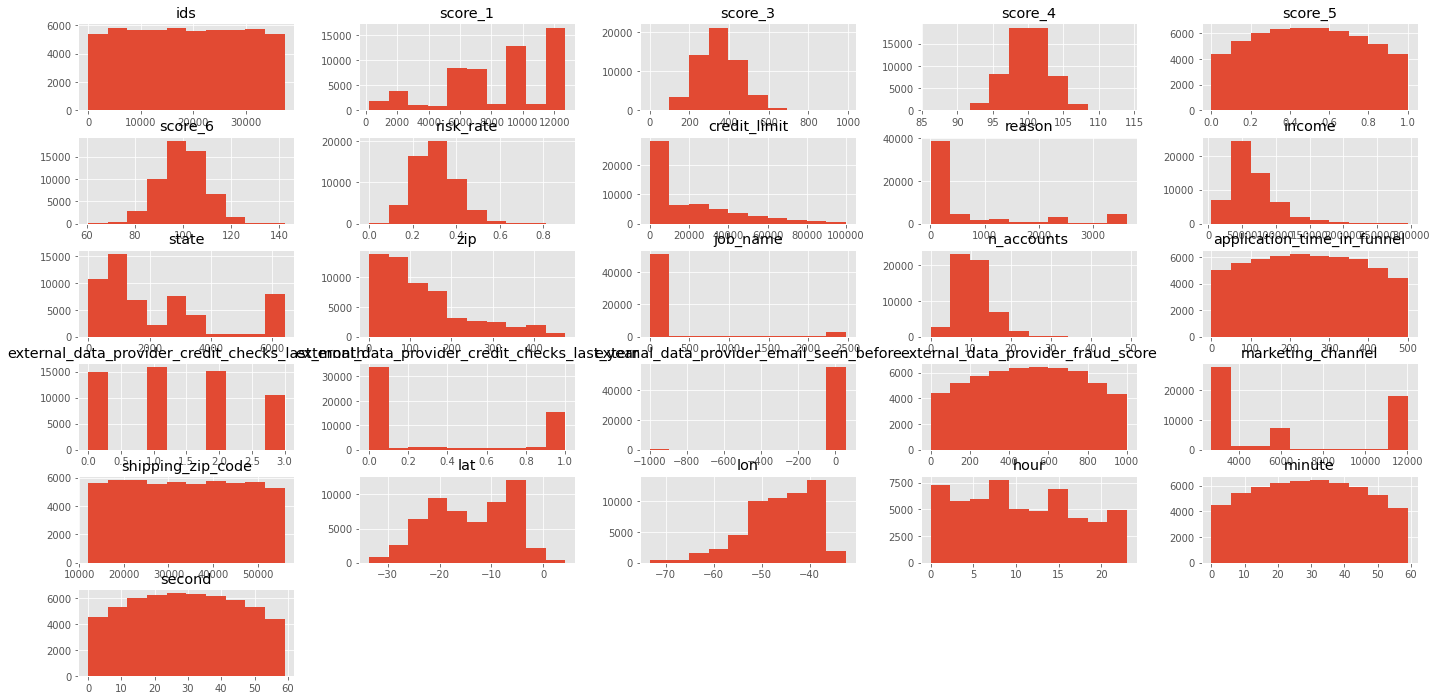

In [40]:
df51.hist(figsize=(24,12));

### 6.1.2.Categorical Variables

In [41]:
categorical_features = df51.select_dtypes(include=['object']).columns

**ANALISES RETIRADAS DOS GRAFICOS ABAIXO:**

Vou analisar coluna por coluna e manter apenas as que eu considerar relevantes para os modelos, caso eu considere que a coluna é irrelevante para o modelo eu vou escolher ela na etapa de Data Filtering, porém o motivo vai estar aqui em baixo, faço isso para deixa meu código mais limpo e mais leve removendo as colunas desnecessárias logo no começo.

**Feature Score_1:**

Embora os valores estejam encodados para manter a segurança das informações dos clientes, podemos ver que temos uma boa distribuição de dados nessa feature, então eu acredito que ela vai ser útil para o modelo depois que passar por um processo de enconder, então eu vou escolher: **Manter essa coluna**

**Feature Score_2:**

Mesma análise que fiz para a coluna score_1, vou escolher: **Manter essa coluna**

**Feature Facebook_Profile:**

Acredito que essa feature também seja relevante para o modelo, pelo fato dela está bem distribuída e não tendendo para um lado apenas, ou seja, ela não é desbalanceada completamente, e também a informação que ela carrega e importante pois talvez um cliente que vá ser inadimplente não possua Facebook por que não gosta de ser mostrar ou o contrário e claro, quem vai dizer no fim se e relevante ou não é o modelo, por isso vou escolher: **Manter essa coluna**

**Feature State:**

Mesma análise que fiz para score 1 e 2, vou escolher: **Manter essa coluna**

**Feature Channel:**

Essa já e diferente das outras features, pois só possui um valor apenas, ou seja, não tem informação que vá ajuda o modelo a prever o fenômeno pelo motivo de não ter variedade de dados, por isso eu vou escolher: **Remover essa coluna**


**Feature real_state:**

Essa feature já não possui uma boa distribuição de dados, estando desbalanceada para algumas classes, porém eu vou escolher **Manter ela**, já que me parece relevante.


**Feature E-mail:**

Nessa feature eu pude identificar um erro, que é o nome dos e-mails, pode ter sido algum erro de digitação ou de sistema pois o gmail está escrito com dois L e o hotmail também em algumas linhas, por isso o desbalanceamento nessa coluna, para resolver isso eu vou escolher: **Manter essa coluna** e também tratar ela, esse tratamento vai ser feito na etapa de **Data Description**, então não terá mais esse erro quando for olha o gráfico abaixo, porém vou deixa aqui documentado onde eu encontrei esse erro e onde ele vai ser resolvido.


**Feature marketing_channel:**

Não acredito que essa feature vá impactar o modelo a acerta mais ou menos pela informação que ela carrega, porém está com uma boa distribuição de valores e eu posso estar errado, então vou escolher: **Manter essa coluna**, na etapa de Feature Selection mais pra frente vou usar técnicas mais avançadas para escolher as colunas, então tendo dúvida eu vou deixar a feature.


**Feature shipping_state:**

Mesma análise que fiz para marketing channel, vou escolher: **Manter essa coluna** embora não a ache tão importante para o modelo, mas como já disse antes mais pra frente vamos ter uma etapa só com foco em escolher as melhores colunas então até lá na dúvida e melhor deixa as colunas.

**Feature Class:**

Essa foi uma coluna criada por mim na etapa de Feature Engienner então vou escolher: **Manter ela** embora esteja meio desbalanceada, mas ainda sim acho relevante para o modelo.


**Outras Features:**

Estou removendo as features com muitos valores distintos das minhas análises, estou meio que "Empurrando o problema com a barriga", pois são features que acho relevante mas que não chegou o momento ainda de focar no melhor enconder para elas, por isso vou continuar removendo, pois já na próxima etapa eu vou finalmente usar minhas features categóricas já que é a parte de Data Preparation.

Count plot for feature facebook_profile is ↓


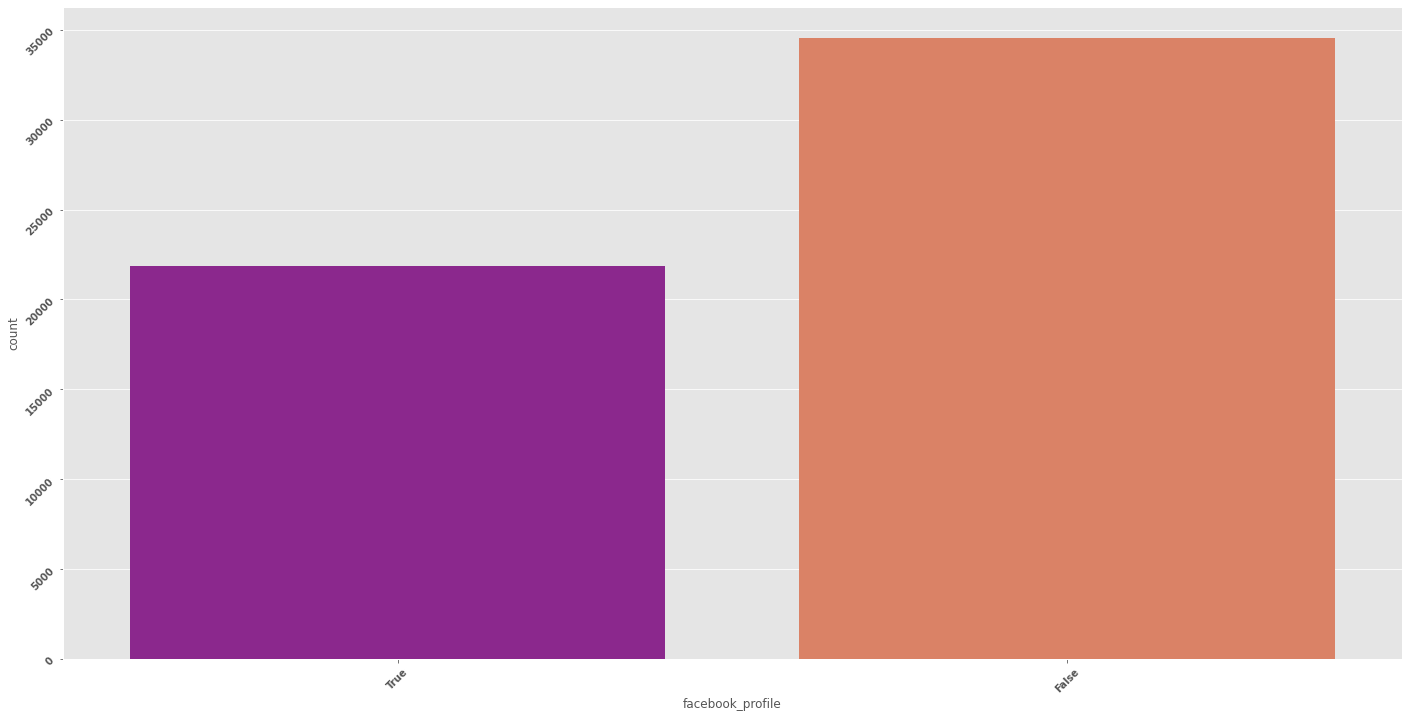

Count plot for feature real_state is ↓


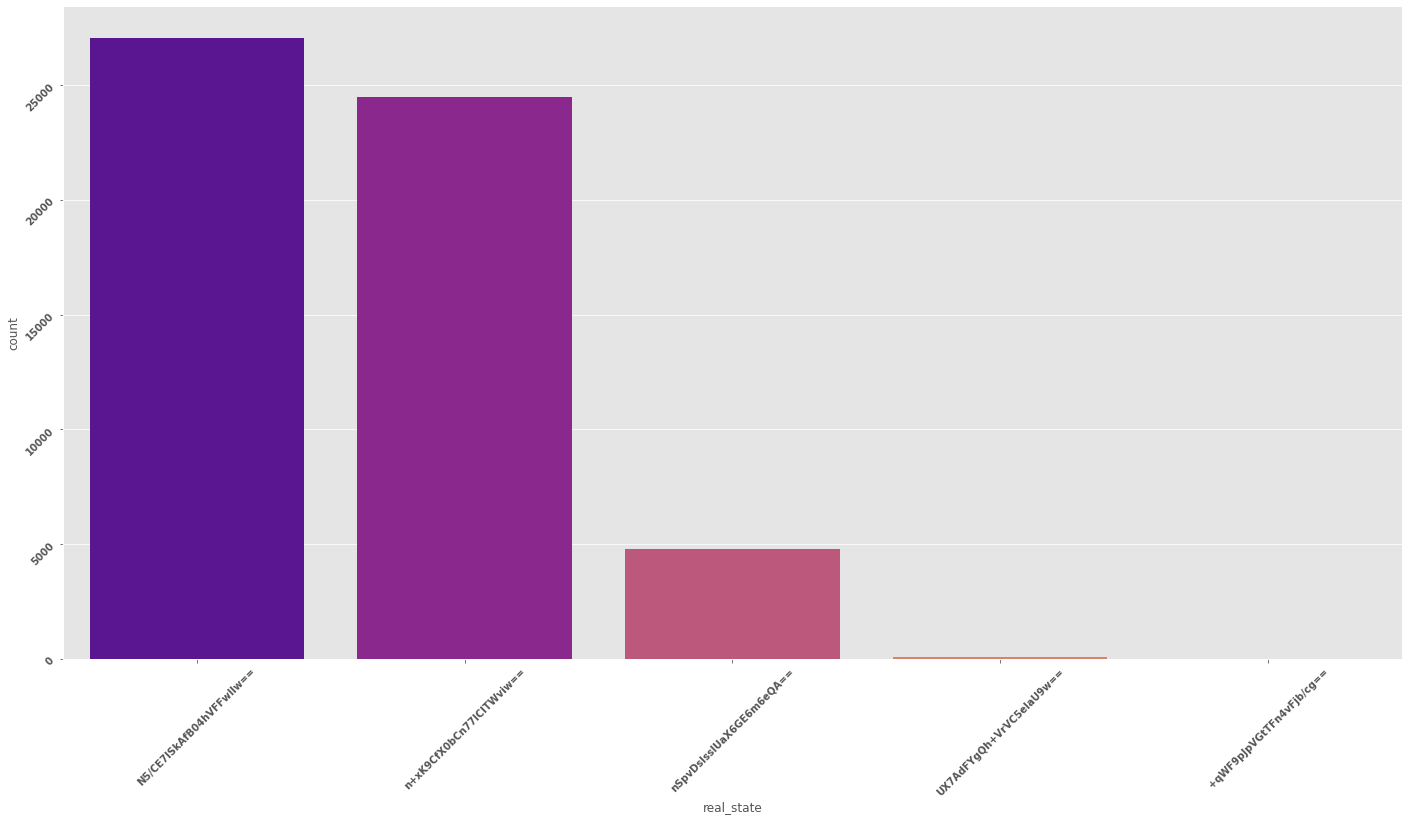

Count plot for feature email is ↓


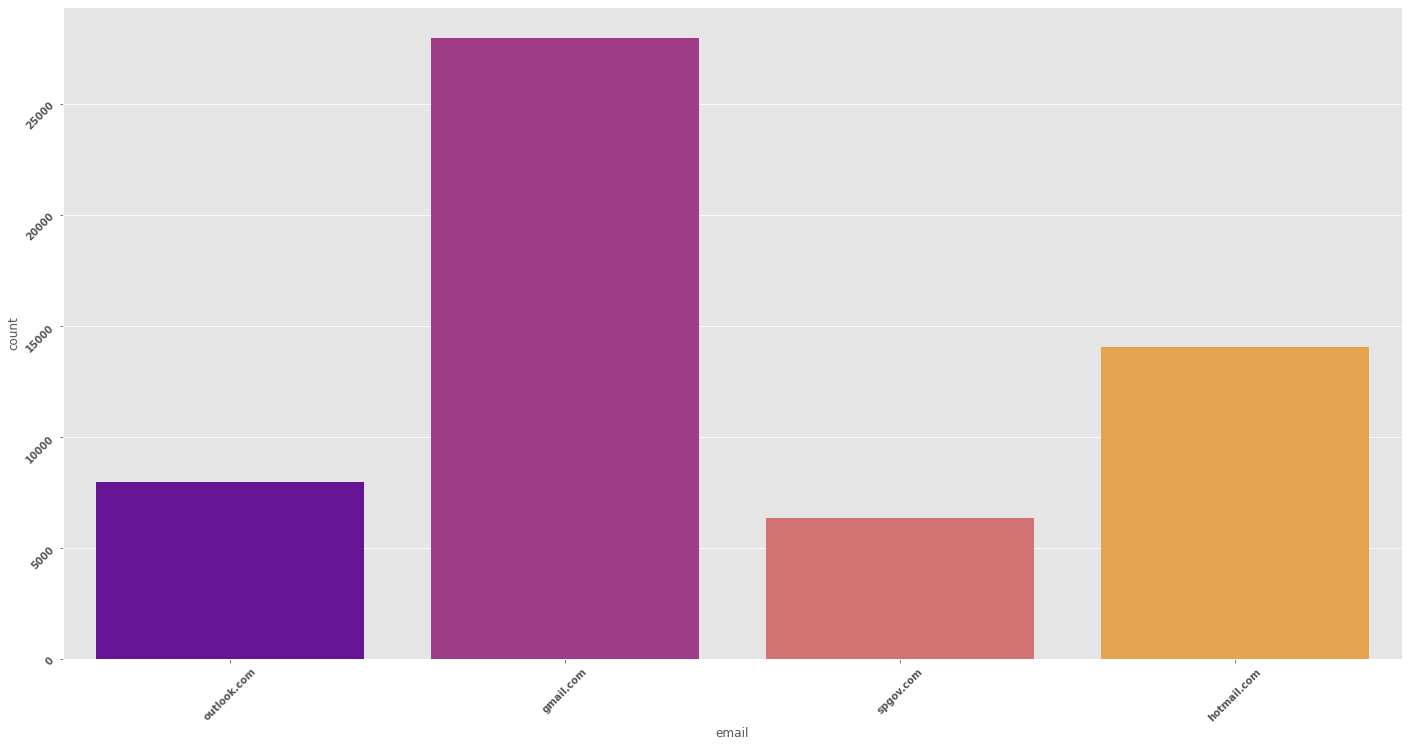

Count plot for feature shipping_state is ↓


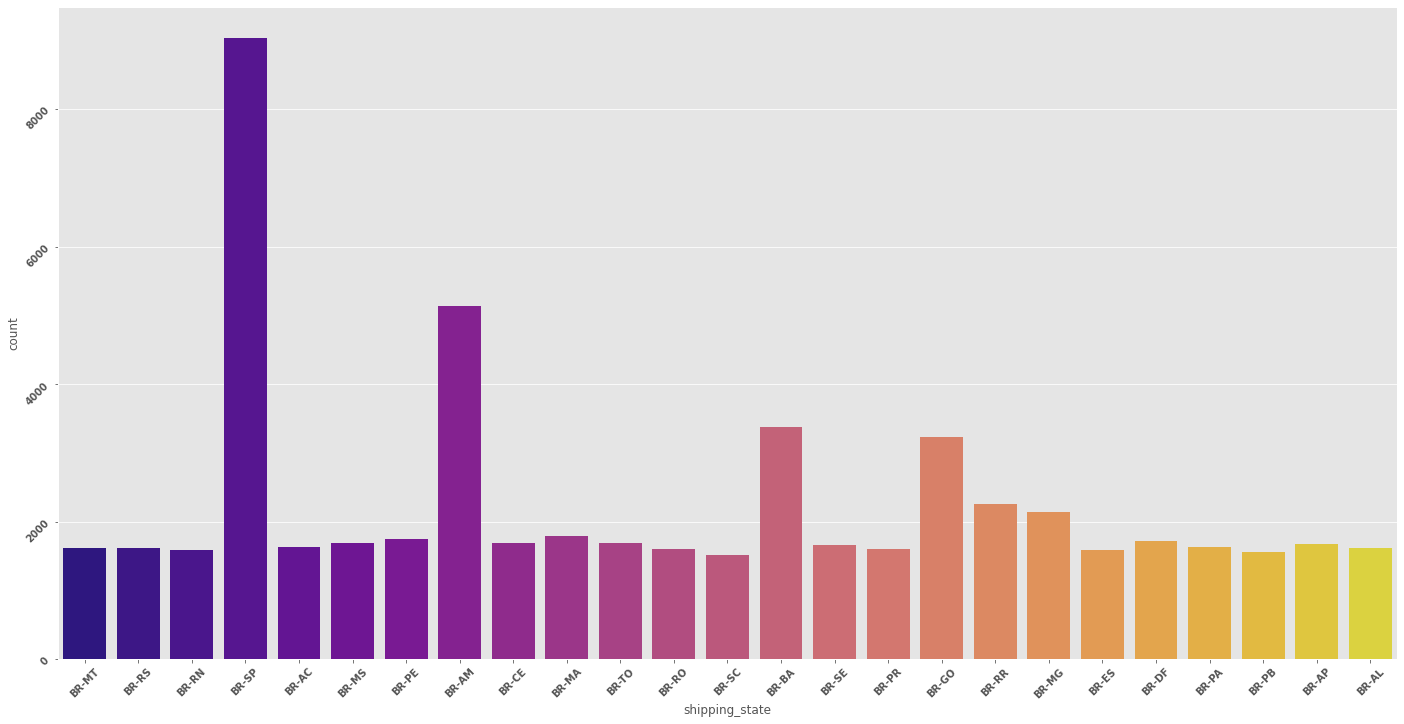

Count plot for feature class is ↓


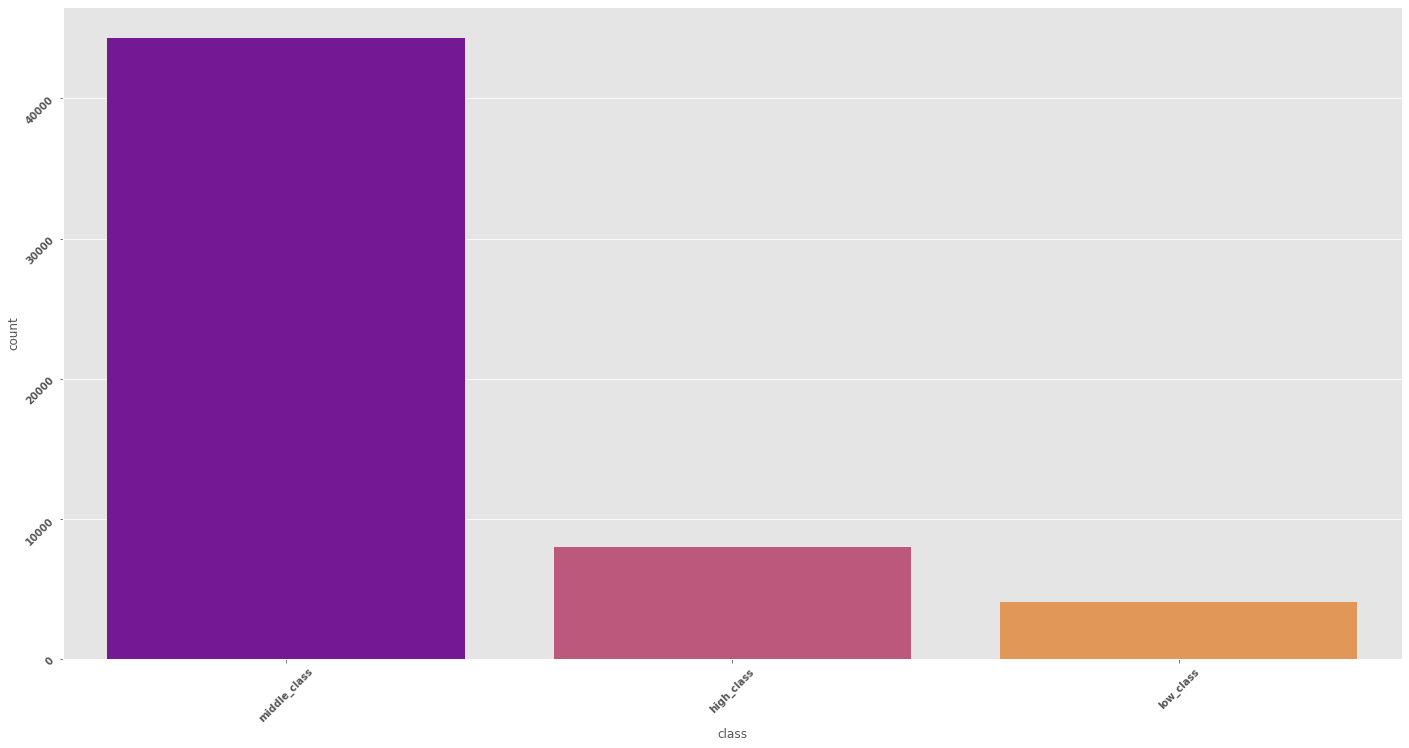

Count plot for feature target_default is ↓


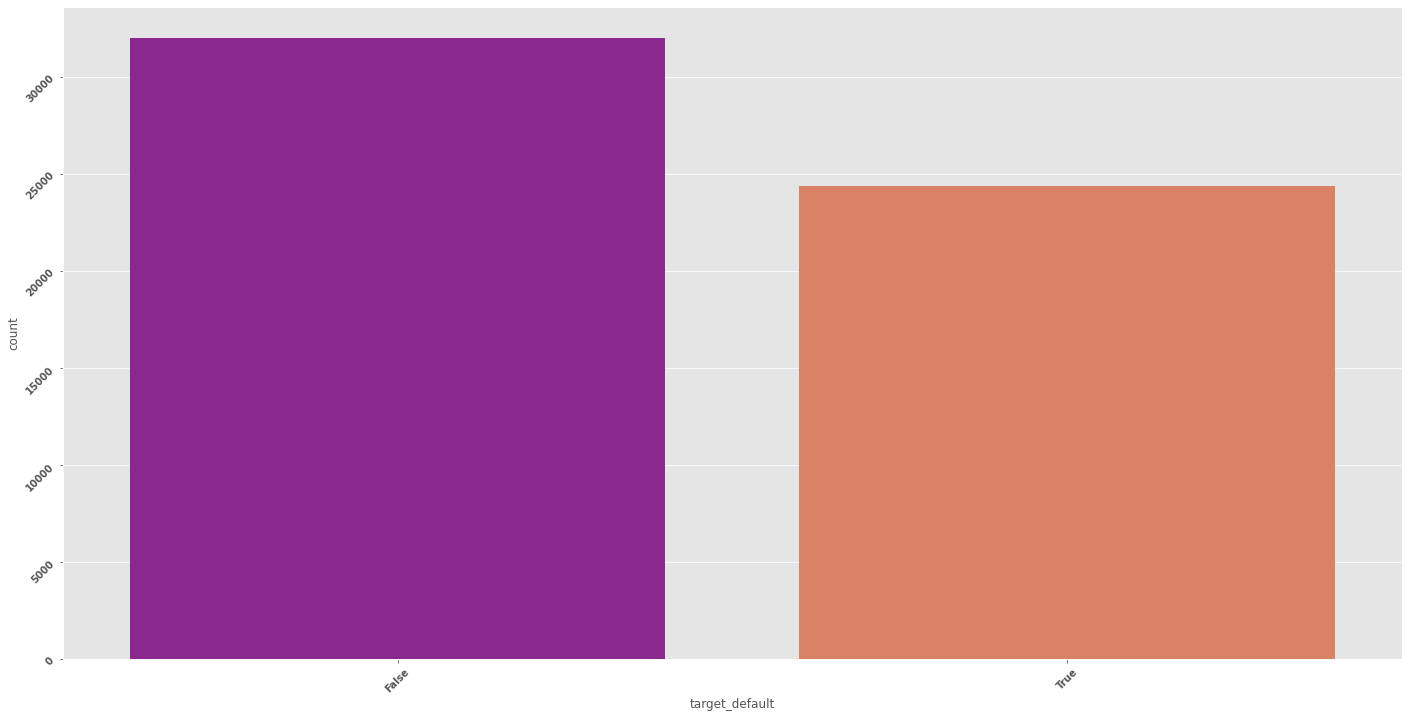

In [42]:
for col in categorical_features:
    print(f'Count plot for feature {col} is ↓')
    getcountplot(df51,col)
    print('='*75)

## 6.2.Bivariate Analysis - Hypothesis Validation(Unbalanced Dataset)¶

### H1:Clientes com renda menor de 80 mil reais por ano representa 30% dos meus clientes.
**FALSA:** Na verdade clientes com renda menor de 80 MIL REPRESENTAM 140% DOS MEUS CLIENTES.

In [43]:
aux  = pd.DataFrame(df5[df5['income'] > 80000]['ids'].count(),index=[0],columns=['data_after_80_mil'])
aux1 = pd.DataFrame(df5[df5['income'] < 80000]['ids'].count(),index=[0],columns=['data_before_80_mil'])
aux3 = pd.concat([aux,aux1],axis=1).T
aux3.columns = ['Valeus']
aux3['% Diference'] = round(100*aux3['Valeus'].pct_change().fillna(0),2)
aux3

,Valeus,% Diference
data_after_80_mil,11002,0.00
data_before_80_mil,26352,139.52


### H2:O numero de contas criadas aumenta 30% depois das 7 horas da noite.
**FALSA:** O número de contas criadas **DIMINUI DEPOIS DAS 7 HORAS**. diminuição de 15 %.

In [44]:
aux = df5[['hour','n_accounts']].groupby('hour').sum()
aux.columns = ['Number of account created']
aux['% diference'] = round(100*aux['Number of account created'].pct_change().fillna(0),2)
aux

,Number of account created,% diference
hour,,
0,17396.0,0.00
1,18834.0,8.27
2,18153.0,-3.62
3,17707.0,-2.46
4,17910.0,1.15
5,19108.0,6.69
6,18493.0,-3.22
7,15593.0,-15.68
8,15680.0,0.56


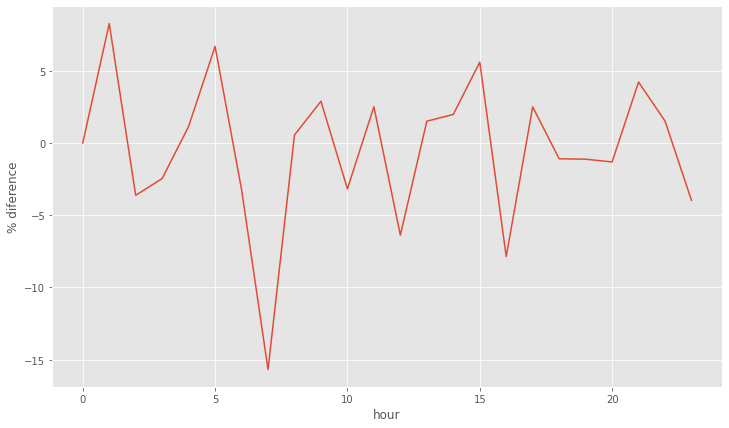

In [45]:
plt.figure(figsize=(12,7))
sns.lineplot(x=aux.index,y=aux['% diference']);

### H3:O canal de Marketing Website representa 40% das pessoas da minha base, em comparação com todos os outros.
**FALSA:** O canal de Website representa 32% dos meus clientes na base e não 40%.

In [46]:
pd.DataFrame(df3['marketing_channel'].value_counts(normalize=True))

,marketing_channel
Website,0.321866
Waiting-list,0.155218
Invite-web,0.078144
Radio-commercial,0.075547
Facebook,0.074771
LinkedIn,0.074557
Twitter,0.074289
Instagram,0.073834
Invite-email,0.071773


In [47]:
aux =  pd.DataFrame(df3[df3['marketing_channel'] == 'Website']['marketing_channel'].count(),columns=['Marketing_WebSite'],index=[0])
aux1 = pd.DataFrame(df3[df3['marketing_channel'] != 'Website']['marketing_channel'].count(),columns=['Others_marketing_channel'],index=[0])
aux3 = pd.concat([aux,aux1],axis=1).T
aux3.columns = ['Values']
aux3['% Difference'] = round(100*aux3['Values'].pct_change().fillna(0),2)
aux3

,Values,% Difference
Marketing_WebSite,12023,0.00
Others_marketing_channel,25331,110.69


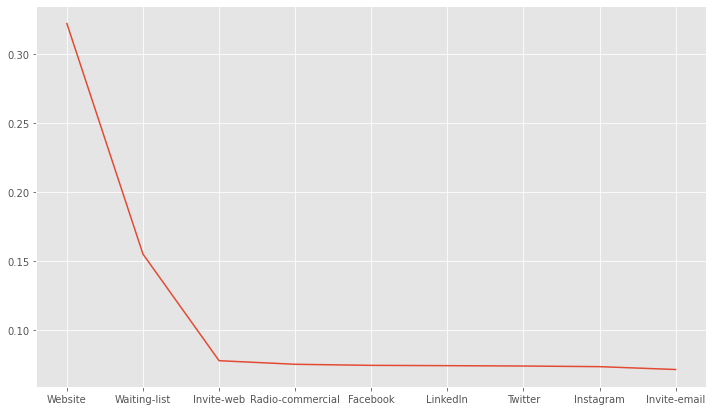

In [81]:
plt.figure(figsize=(12,7))
sns.lineplot(x=df3['marketing_channel'].value_counts(normalize=True).index,
             y=df3['marketing_channel'].value_counts(normalize=True).values);

### H4:Pessoas da classe média possuem limite de crédito 30%  maior ou mais do que pessoas da classe baixa, na média.
**VERDADEIRA:** 
Clientes que considerei da classe média são a maioria esmagadora dos meus clientes, então a hipotese É  VERDADEIRA POIS O LIMITE MÉDIO DE CREDITO AUMENTA 210% PARA CLIENTES DA CLASSE MÉDIA.

In [49]:
df5['class'].value_counts()

middle_class    28953
high_class       5832
low_class        2569
Name: class, dtype: int64

In [50]:
aux = df5[(df5['class'] == 'middle_class') | (df5['class'] == 'low_class')]
aux1 = aux[['class','credit_limit']].groupby('class').mean().rename(columns={'credit_limit':'mean_credit_limit'})
aux1['% Difference'] = round(100*aux1['mean_credit_limit'].pct_change().fillna(0),2)
aux1

,mean_credit_limit,% Difference
class,,
low_class,5982.502919,0.00
middle_class,18598.435844,210.88


### H5:Clientes que passam menos de 200 minutos no funil de vendas, possuem o limite de credito 20% maior ou mais que os outros, na média.
**FALSA:** Clientes que passam menos de 200 minutos no funil de vendas possuem UM LIMITE DE CREDITO 32% MENOR DO QUE OS OUTROS CLIENTES NA MEDIA.

In [51]:
aux =  pd.DataFrame(df5[df5['application_time_in_funnel'] > 200]['credit_limit'].sum(),columns=['Time_after_200'],index=[0])
aux2 = pd.DataFrame(df5[df5['application_time_in_funnel'] < 200]['credit_limit'].sum(),columns=['Time_before_200'],index=[0])
aux3 = pd.concat([aux,aux2],axis=1).T
aux3.columns = ['mean_credit_limit']
aux3['% Difference'] = round(100*aux3['mean_credit_limit'].pct_change().fillna(0),2)
aux3

,mean_credit_limit,% Difference
Time_after_200,422537986.0,0.00
Time_before_200,287065947.0,-32.06


## 6.3.Multivariate Analysis - (Balanced DataSet)

**REMOVENDO COLUNAS MUITO CORRELACIONADAS:**
Vou excluir colunas que possuam uma correlação muito forte, pois não faz sentido manter colunas que falam praticamente a mesma coisa, abaixo eu vou lista as colunas e o motivo da remoção.

- Numéricas:

**N_issues:** Pelo motivo de ter uma correlação de 86% com a feature de n_accounts e entre as duas eu prefiro ficar com a n_accounts, então ela foi **REMOVIDA**


- Categóricas:

**Score_2:** Vou remover ela pela extrema correlação com a feature de score_1, pelo motivo dela ter 35 valores distintos enquanto a score_1 tem 7, ou seja, com 7 valores representa os 35 da score_2, isso vai facilitar para mim na hora do enconder e vai deixar o projeto muito mais leve, então ela foi **REMOVIDA**.

OBS: Lembrando que eu removo todas as colunas na parte de Data Filtering, aqui eu só deixo o motivo, mas quando você estiver vendo o gráfico abaixo essa correlação não vai existir mais, pois eu já removi essa feature, faço isso para deixar o projeto mais leve, por exemplo menos colunas na hora de balancear meus dados.

### 6.3.1.Numerical Variables

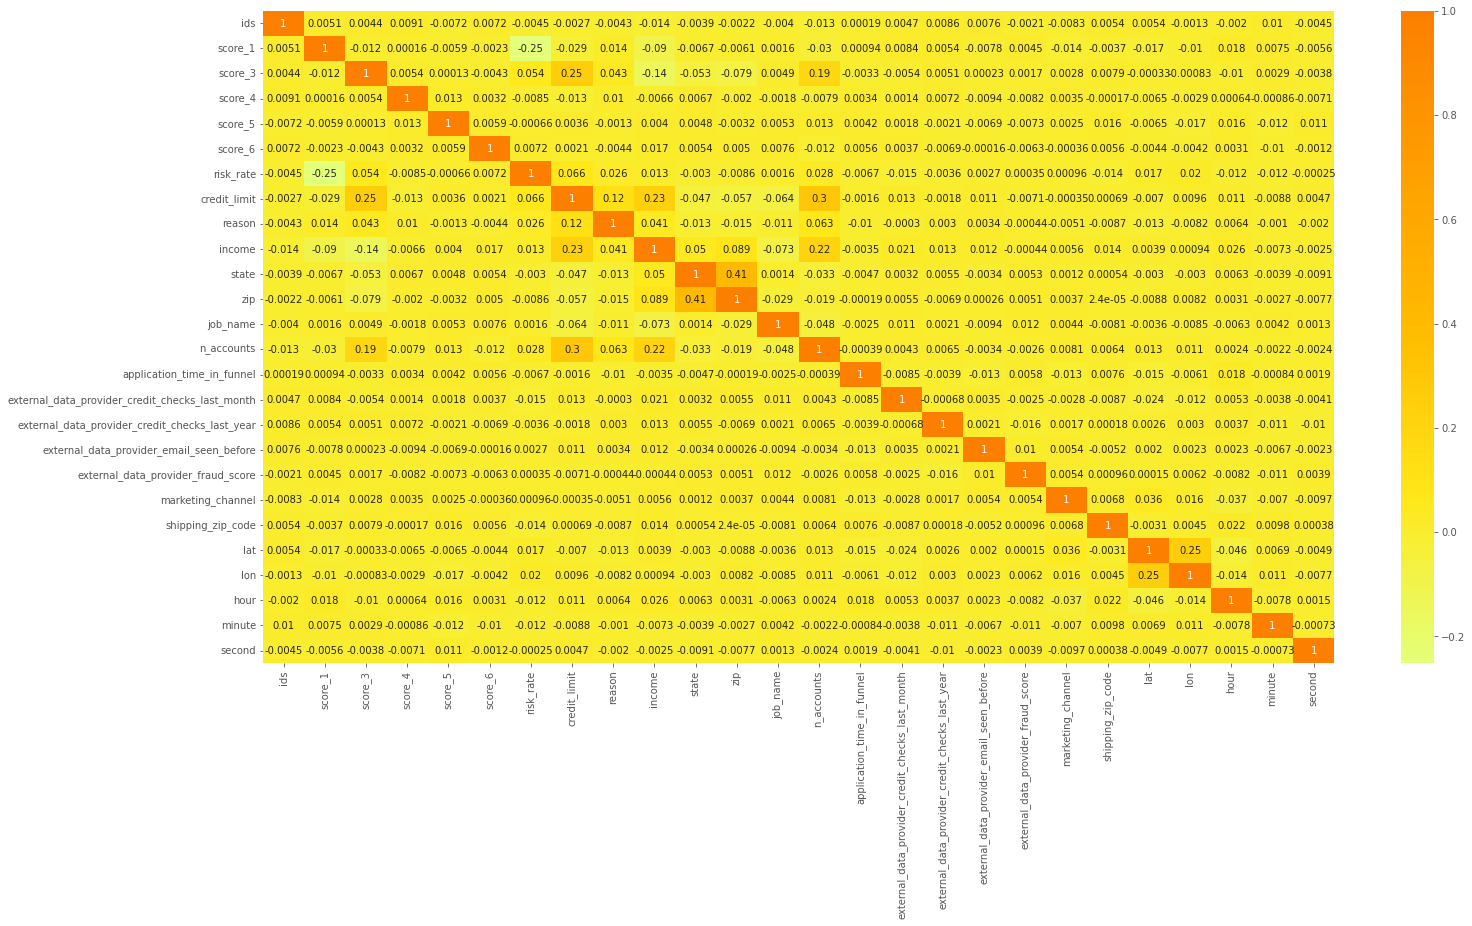

In [52]:
plt.figure(figsize=(24,12))
sns.heatmap(df51.corr(),cmap='Wistia',annot=True);

### 6.3.2.Categorical Variables

In [53]:
cat_attributes = df5.select_dtypes(include=['object'])

In [54]:
cat_attributes_list = cat_attributes.columns.tolist()
corr_dict = {}

for i in range(len(cat_attributes_list)):
    corr_ls = []
    for j in range(len(cat_attributes_list)):
        ref  = cat_attributes_list[i]
        feat = cat_attributes_list[j]   
        
        #correlations
        corr = cramer_v(cat_attributes[ref],cat_attributes[feat])
        
        #append list
        corr_ls.append(corr)
    #append a correlation list for each ref attributes
    corr_dict[ref] = corr_ls

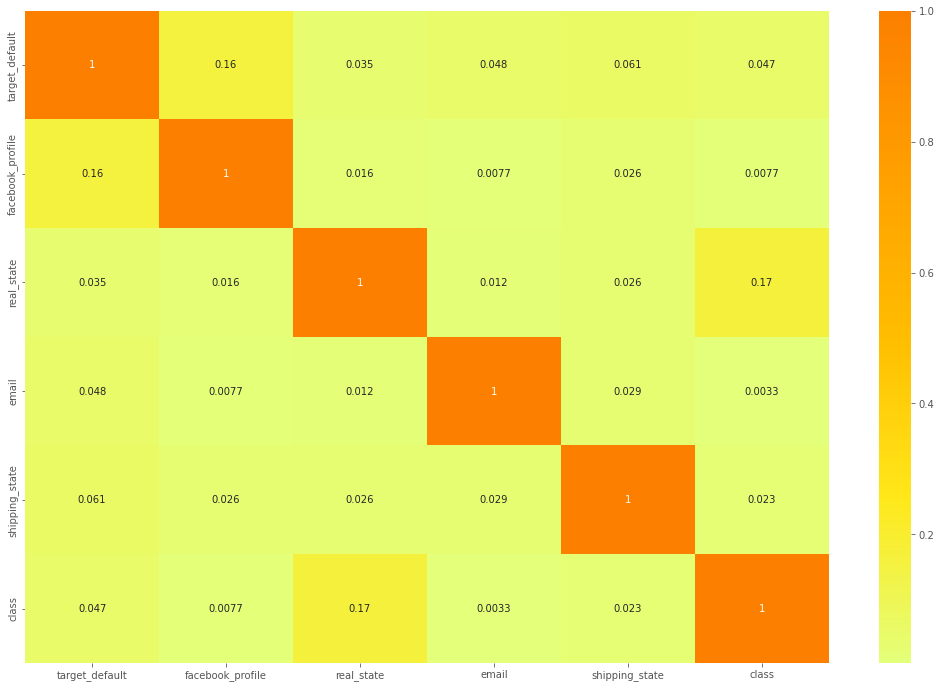

In [55]:
#Correlations to dataframe
categorical_corr = pd.DataFrame(corr_dict)
categorical_corr = categorical_corr.set_index(categorical_corr.columns)

#Show correlations
plt.figure(figsize=(18,12))
sns.heatmap(categorical_corr,cmap='Wistia',annot=True);

# 7.0.Data Preparation

In [56]:
df6 = df51.copy()
df6.head()

,ids,score_1,score_3,score_4,score_5,score_6,risk_rate,credit_limit,reason,income,state,zip,job_name,n_accounts,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,marketing_channel,shipping_zip_code,lat,lon,hour,minute,second,facebook_profile,real_state,email,shipping_state,class,target_default
0,7582,9233,350.0,101.800832,0.259555,108.427273,0.40,0.0,30,65014.12,2833,317,1,18.0,444,2,0.0,51.0,645,2681,17528,-29.151546,-51.138646,7,52,34,True,N5/CE7lSkAfB04hVFFwllw==,outlook.com,BR-MT,middle_class,False
1,27409,12701,370.0,97.062615,0.942655,92.002546,0.24,39726.0,262,100018.91,6398,305,1,14.0,346,1,0.0,17.0,243,2822,40933,-19.687711,-47.941515,2,34,29,False,N5/CE7lSkAfB04hVFFwllw==,gmail.com,BR-RS,high_class,False
2,30719,9233,510.0,101.599485,0.987673,94.902491,0.32,54591.0,812,68830.01,402,84,2,19.0,406,3,0.0,38.0,815,5798,37825,-17.520650,-39.758011,11,20,49,False,n+xK9CfX0bCn77lClTWviw==,spgov.com,BR-RN,middle_class,False
3,23114,5371,500.0,98.474289,0.532539,118.126207,0.18,0.0,1,60011.29,6398,267,1,11.0,240,2,1.0,46.0,320,2681,52827,-16.574259,-39.909901,13,39,3,True,n+xK9CfX0bCn77lClTWviw==,gmail.com,BR-MT,middle_class,False
4,12065,5371,300.0,101.837040,0.915389,90.711273,0.44,61055.0,8,75024.28,1290,21,1,9.0,169,2,1.0,21.0,811,12023,55266,-6.762413,-35.132246,5,27,2,False,N5/CE7lSkAfB04hVFFwllw==,gmail.com,BR-SP,middle_class,False


## 7.1.Rescaling

### 7.1.1.Normalization

In [57]:
ss = StandardScaler()

In [58]:
df6['score_3'] = ss.fit_transform(df6[['score_3']].values)

df6['score_4'] = ss.fit_transform(df6[['score_4']].values)

df6['score_6'] = ss.fit_transform(df6[['score_6']].values)

df6['risk_rate'] = ss.fit_transform(df6[['risk_rate']].values)

### 7.1.2.Rescaling Normal

In [59]:
mms = MinMaxScaler()

In [60]:
df6['application_time_in_funnel'] = mms.fit_transform(df6[['application_time_in_funnel']].values)

df6['external_data_provider_fraud_score'] = mms.fit_transform(df6[['external_data_provider_fraud_score']].values)

df6['shipping_zip_code'] = mms.fit_transform(df6[['shipping_zip_code']].values)

df6['hour'] = mms.fit_transform(df6[['hour']].values)

df6['minute'] = mms.fit_transform(df6[['minute']].values)

df6['second'] = mms.fit_transform(df6[['second']].values)

### 7.1.3.Rescaling Robust

In [61]:
rs = RobustScaler()

In [62]:
df6['credit_limit'] = rs.fit_transform(df6[['credit_limit']].values)

df6['income'] = rs.fit_transform(df6[['income']].values)

df6['n_accounts'] = rs.fit_transform(df6[['n_accounts']].values)

df6['external_data_provider_credit_checks_last_month'] = rs.fit_transform(df6[['external_data_provider_credit_checks_last_month']].values)

df6['external_data_provider_credit_checks_last_year'] = rs.fit_transform(df6[['external_data_provider_credit_checks_last_year']].values)

df6['external_data_provider_email_seen_before'] = rs.fit_transform(df6[['external_data_provider_email_seen_before']].values)

df6['lat'] = rs.fit_transform(df6[['lat']].values)

df6['lon'] = rs.fit_transform(df6[['lon']].values)

## 7.2.Enconders

### 7.2.1Label Enconder

In [63]:
aux = {'False':0,'True':1}
df6['target_default']   = df6['target_default'].map(aux)
df6['facebook_profile'] = df6['facebook_profile'].map(aux)

### 7.2.2.One Hot Enconder

In [64]:
df6 = pd.get_dummies(df6,prefix=['email'],columns=['email'])

df6 = pd.get_dummies(df6,prefix=['class'],columns=['class'])

df6 = pd.get_dummies(df6,prefix=['shipping_state'],columns=['shipping_state'])

df6 = pd.get_dummies(df6,prefix=['real_state'],columns=['real_state'])

In [65]:
df6.head()

,ids,score_1,score_3,score_4,score_5,score_6,risk_rate,credit_limit,reason,income,state,zip,job_name,n_accounts,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,marketing_channel,shipping_zip_code,lat,lon,hour,minute,second,facebook_profile,target_default,email_gmail.com,email_hotmail.com,email_outlook.com,email_spgov.com,class_high_class,class_low_class,class_middle_class,shipping_state_BR-AC,shipping_state_BR-AL,shipping_state_BR-AM,shipping_state_BR-AP,shipping_state_BR-BA,shipping_state_BR-CE,shipping_state_BR-DF,shipping_state_BR-ES,shipping_state_BR-GO,shipping_state_BR-MA,shipping_state_BR-MG,shipping_state_BR-MS,shipping_state_BR-MT,shipping_state_BR-PA,shipping_state_BR-PB,shipping_state_BR-PE,shipping_state_BR-PR,shipping_state_BR-RN,shipping_state_BR-RO,shipping_state_BR-RR,shipping_state_BR-RS,shipping_state_BR-SC,shipping_state_BR-SE,shipping_state_BR-SP,shipping_state_BR-TO,real_state_+qWF9pJpVGtTFn4vFjb/cg==,real_state_N5/CE7lSkAfB04hVFFwllw==,real_state_UX7AdFYgQh+VrVC5eIaU9w==,real_state_n+xK9CfX0bCn77lClTWviw==,real_state_nSpvDsIsslUaX6GE6m6eQA==
0,7582,9233,0.009726,0.597899,0.259555,0.910669,1.019457,-0.312574,30,0.128857,2833,317,1,1.490983,0.888,0.5,0.0,0.871326,0.645,2681,0.125616,-1.124137,-0.555673,0.304348,0.881356,0.576271,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,27409,12701,0.202914,-0.989382,0.942655,-0.837009,-0.639870,0.929158,262,1.026565,6398,305,1,0.745491,0.692,0.0,0.0,-0.225899,0.243,2822,0.657560,-0.429276,-0.246783,0.086957,0.576271,0.491525,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,30719,9233,1.555233,0.530449,0.987673,-0.528439,0.189794,1.393800,812,0.226716,402,84,2,1.677356,0.812,1.0,0.0,0.451799,0.815,5798,0.586922,-0.270165,0.543866,0.478261,0.338983,0.830508,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,23114,5371,1.458639,-0.516478,0.532539,1.942687,-1.262117,-0.312574,1,0.000557,6398,267,1,0.186373,0.480,0.5,1.0,0.709969,0.320,2681,0.927885,-0.200679,0.529191,0.565217,0.661017,0.050847,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,12065,5371,-0.473245,0.610029,0.915389,-0.974407,1.434289,1.595848,8,0.385570,1290,21,1,-0.186373,0.338,0.5,1.0,-0.096814,0.811,12023,0.983318,0.519734,0.990783,0.217391,0.457627,0.033898,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [66]:
data_dimensions(df6)

Number of Rows: 56414
Number of Columns: 65


# 8.0.Feature Selection

**Selecionando as Melhores colunas:**

Essa é uma das etapas que mais melhoram a perfomance dos  modelos e a simplificação na hora de fazer deploy, pois aqui eu busco deixar apenas as colunas que tem a maior relevancia para o modelo, ou seja, deixando o modelo mais simples e menos complexos.


**Técnica:**

Vou usar o Boruta para fazer o Feature Selection.

In [67]:
df7 = df6.copy() # Balanced Dataset

In [68]:
X = df7.drop('target_default',axis=1)
y = df7['target_default']

In [69]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=32)

In [70]:
x_train = X_train.drop('ids',axis=1)
x_test  = X_test.drop('ids',axis=1)

## 8.1.Boruta Feature Selection

In [82]:
#X_train_n = x_train.values
#y_train_n = y_train.ravel()

#Random Forest Regressor
#rf = RandomForestRegressor(n_jobs=1)

#define_boruta
#boruta = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42)

#fit_boruta
#boruta.fit(X_train_n,y_train_n)

## 8.2.Best Features from Boruta

In [83]:
#cols_seleceted = boruta.support_.tolist()

#best_features
#cols_selected_boruta = X.iloc[:,cols_seleceted].columns.tolist()

#not selected
#cols_not_selected_boruta = list(np.setdiff1d(X.columns,cols_selected_boruta))

In [71]:
cols_selected_boruta_save = ['score_1',
                             'score_3',
                             'score_4',
                             'score_5',
                             'score_6',
                             'risk_rate',
                             'income',
                             'state',
                             'zip',
                             'n_accounts',
                             'application_time_in_funnel',
                             'external_data_provider_credit_checks_last_year',
                             'external_data_provider_email_seen_before',
                             'external_data_provider_fraud_score',
                             'marketing_channel',
                             'shipping_zip_code',
                             'lat',
                             'lon',
                             'hour',
                             'facebook_profile']

cols_not_selected_boruta_save = ['class_high_class',
                                 'class_low_class',
                                 'class_middle_class',
                                 'credit_limit',
                                 'email_gmail.com',
                                 'email_hotmail.com',
                                 'email_outlook.com',
                                 'email_spgov.com',
                                 'external_data_provider_credit_checks_last_month',
                                 'job_name',
                                 'minute',
                                 'real_state_+qWF9pJpVGtTFn4vFjb/cg==',
                                 'real_state_N5/CE7lSkAfB04hVFFwllw==',
                                 'real_state_UX7AdFYgQh+VrVC5eIaU9w==',
                                 'real_state_n+xK9CfX0bCn77lClTWviw==',
                                 'real_state_nSpvDsIsslUaX6GE6m6eQA==',
                                 'reason',
                                 'second',
                                 'shipping_state_BR-AC',
                                 'shipping_state_BR-AL',
                                 'shipping_state_BR-AM',
                                 'shipping_state_BR-AP',
                                 'shipping_state_BR-BA',
                                 'shipping_state_BR-CE',
                                 'shipping_state_BR-DF',
                                 'shipping_state_BR-ES',
                                 'shipping_state_BR-GO',
                                 'shipping_state_BR-MA',
                                 'shipping_state_BR-MG',
                                 'shipping_state_BR-MS',
                                 'shipping_state_BR-MT',
                                 'shipping_state_BR-PA',
                                 'shipping_state_BR-PB',
                                 'shipping_state_BR-PE',
                                 'shipping_state_BR-PR',
                                 'shipping_state_BR-RN',
                                 'shipping_state_BR-RO',
                                 'shipping_state_BR-RR',
                                 'shipping_state_BR-RS',
                                 'shipping_state_BR-SC',
                                 'shipping_state_BR-SE',
                                 'shipping_state_BR-SP',
                                 'shipping_state_BR-TO']

# 9.0.Machine Learning Models

In [72]:
#Cols Selected Boruta
x_train = x_train[cols_selected_boruta_save]
x_test  = x_test[cols_selected_boruta_save]

## 9.1.BaseLine Model

In [73]:
target_list = df7['target_default'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
target_weights = df7['target_default'].value_counts(normalize=True).sort_index().tolist()

baseline_model = random.choices(population=target_list,
                                k=k_num,
                                weights=target_weights)

## 9.2.GaussianNB

In [74]:
model_gaussian = GaussianNB()

#train model
model_gaussian.fit(x_train,y_train)

#predict
result_gausian = model_gaussian.predict(x_test)

## 9.3.LogisticRegression

In [75]:
model_logic = LogisticRegression()

#train data
model_logic.fit(x_train,y_train)

#predict
result_logic = model_logic.predict(x_test)

# 10.0.Perfomance

### 10.1.Baseline Model

Accuracy: 51.29%
Balacend Acurracy: 50.38%
Kappa Score: 0.76%
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      9579
           1       0.44      0.44      0.44      7346

    accuracy                           0.51     16925
   macro avg       0.50      0.50      0.50     16925
weighted avg       0.51      0.51      0.51     16925



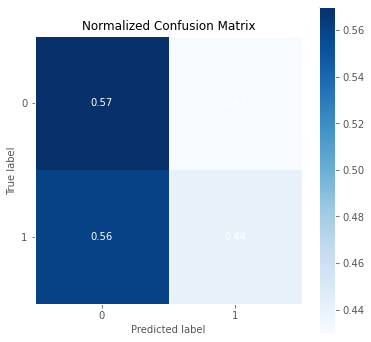

In [76]:
acc = accuracy_score(y_test,baseline_model)
print('Accuracy: {:.2%}'.format(acc))

balacend_acc = balanced_accuracy_score(y_test,baseline_model)
print('Balacend Acurracy: {:.2%}'.format(balacend_acc))

#Kappa Metric
kappa_acc = cohen_kappa_score(y_test,baseline_model)
print('Kappa Score: {:.2%}'.format(kappa_acc))

#classification_report
print(classification_report(y_test,baseline_model))

#plot confusion matrix
mt.plot_confusion_matrix(y_test, baseline_model, normalize=True, figsize=(6,6));

### 10.2.Gaussian

Accuracy: 67.33%
Balacend Acurracy: 68.06%
Kappa Score: 35.20%
              precision    recall  f1-score   support

           0       0.76      0.62      0.68      9579
           1       0.60      0.74      0.66      7346

    accuracy                           0.67     16925
   macro avg       0.68      0.68      0.67     16925
weighted avg       0.69      0.67      0.67     16925



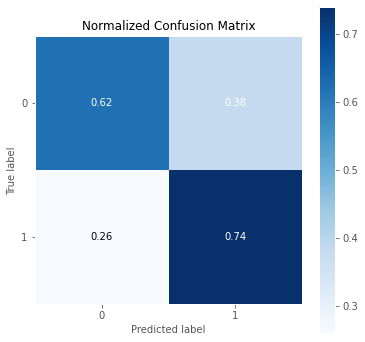

In [77]:
acc = accuracy_score(y_test,result_gausian)
print('Accuracy: {:.2%}'.format(acc))

balacend_acc = balanced_accuracy_score(y_test,result_gausian)
print('Balacend Acurracy: {:.2%}'.format(balacend_acc))

#Kappa Metric
kappa_acc = cohen_kappa_score(y_test,result_gausian)
print('Kappa Score: {:.2%}'.format(kappa_acc))

#classification_report
print(classification_report(y_test,result_gausian))

#plot confusion matrix
mt.plot_confusion_matrix(y_test, result_gausian, normalize=True, figsize=(6,6));

### 10.3.Logistic Regression

Accuracy: 62.51%
Balacend Acurracy: 60.03%
Kappa Score: 20.82%
              precision    recall  f1-score   support

           0       0.64      0.79      0.70      9579
           1       0.60      0.41      0.49      7346

    accuracy                           0.63     16925
   macro avg       0.62      0.60      0.60     16925
weighted avg       0.62      0.63      0.61     16925



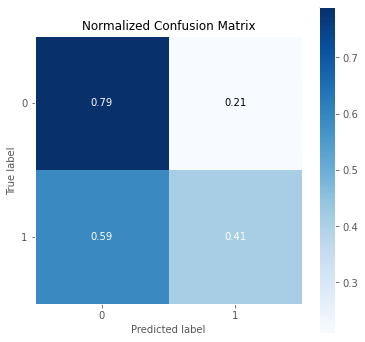

In [78]:
acc = accuracy_score(y_test,result_logic)
print('Accuracy: {:.2%}'.format(acc))

balacend_acc = balanced_accuracy_score(y_test,result_logic)
print('Balacend Acurracy: {:.2%}'.format(balacend_acc))

#Kappa Metric
kappa_acc = cohen_kappa_score(y_test,result_logic)
print('Kappa Score: {:.2%}'.format(kappa_acc))

#classification_report
print(classification_report(y_test,result_logic))

#plot confusion matrix
mt.plot_confusion_matrix(y_test, result_logic, normalize=True, figsize=(6,6));

## 10.4.0.Cross Validation Performance

### 10.4.1.Gaussian CV

Acurracy: 63.23%
Balacend Acurracy: 65.48%
Kappa Score: 29.24%
              precision    recall  f1-score   support

           0       0.78      0.49      0.60      4486
           1       0.55      0.82      0.66      3412

    accuracy                           0.63      7898
   macro avg       0.67      0.65      0.63      7898
weighted avg       0.68      0.63      0.63      7898



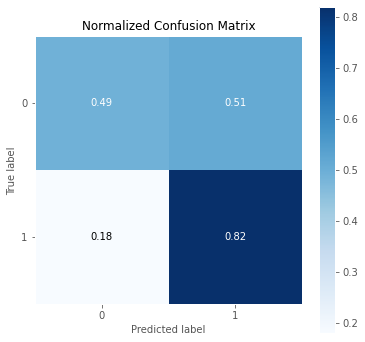

In [79]:
model_gaussian_cv = GaussianNB()
result_gausian_cv = cross_validation(model_gaussian_cv,5,X_train,y_train)

### 10.4.2.Logistic Regression CV

Acurracy: 63.90%
Balacend Acurracy: 61.82%
Kappa Score: 24.32%
              precision    recall  f1-score   support

           0       0.65      0.77      0.71      4486
           1       0.61      0.46      0.53      3412

    accuracy                           0.64      7898
   macro avg       0.63      0.62      0.62      7898
weighted avg       0.63      0.64      0.63      7898



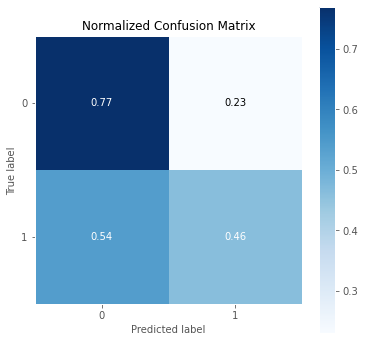

In [80]:
model_logic_cv = LogisticRegression()
result_logic_cv = cross_validation(model_logic_cv,5,X_train,y_train)

# Conclusion
**O que foi feito nesta etapa:**
- Feature Selection:
    - Existem diversos benéficios quando fazemos a seleção das features mais relevantes que são:
        - Torna o Modelo mais facil de intepretar
        - Torna A solução mais facíl de ser utilizada.
        - Reduz o Overfitting
     - Por isso precisamos sempre seguir o pensamento de ter um modelo mais simples possivel, se com 20 colunas conseguimos ter o mesmo resultado de ter 60, então vamos usar 20 pois na hora que o cliente for usar a solução vai ser mais facíl e mais intuitivo na hora de usar.

**O que sera feito na proxima etapa?**
- Machine Learning Models:
    - Aqui eu vou testar novos modelos, vai ser uma etapa focada no Machine Learning apenas, eu vou usar novos modelos, fazer o tunning no modelo que eu escolher, vai ser uma etapa de teste mesmo, pois depois de fazer os ciclos de preparação de dados agora só basta achar o melhor modelo de ML que nos traga a melhor perfomance.

**Proximo passo:**

Machine Learning Models